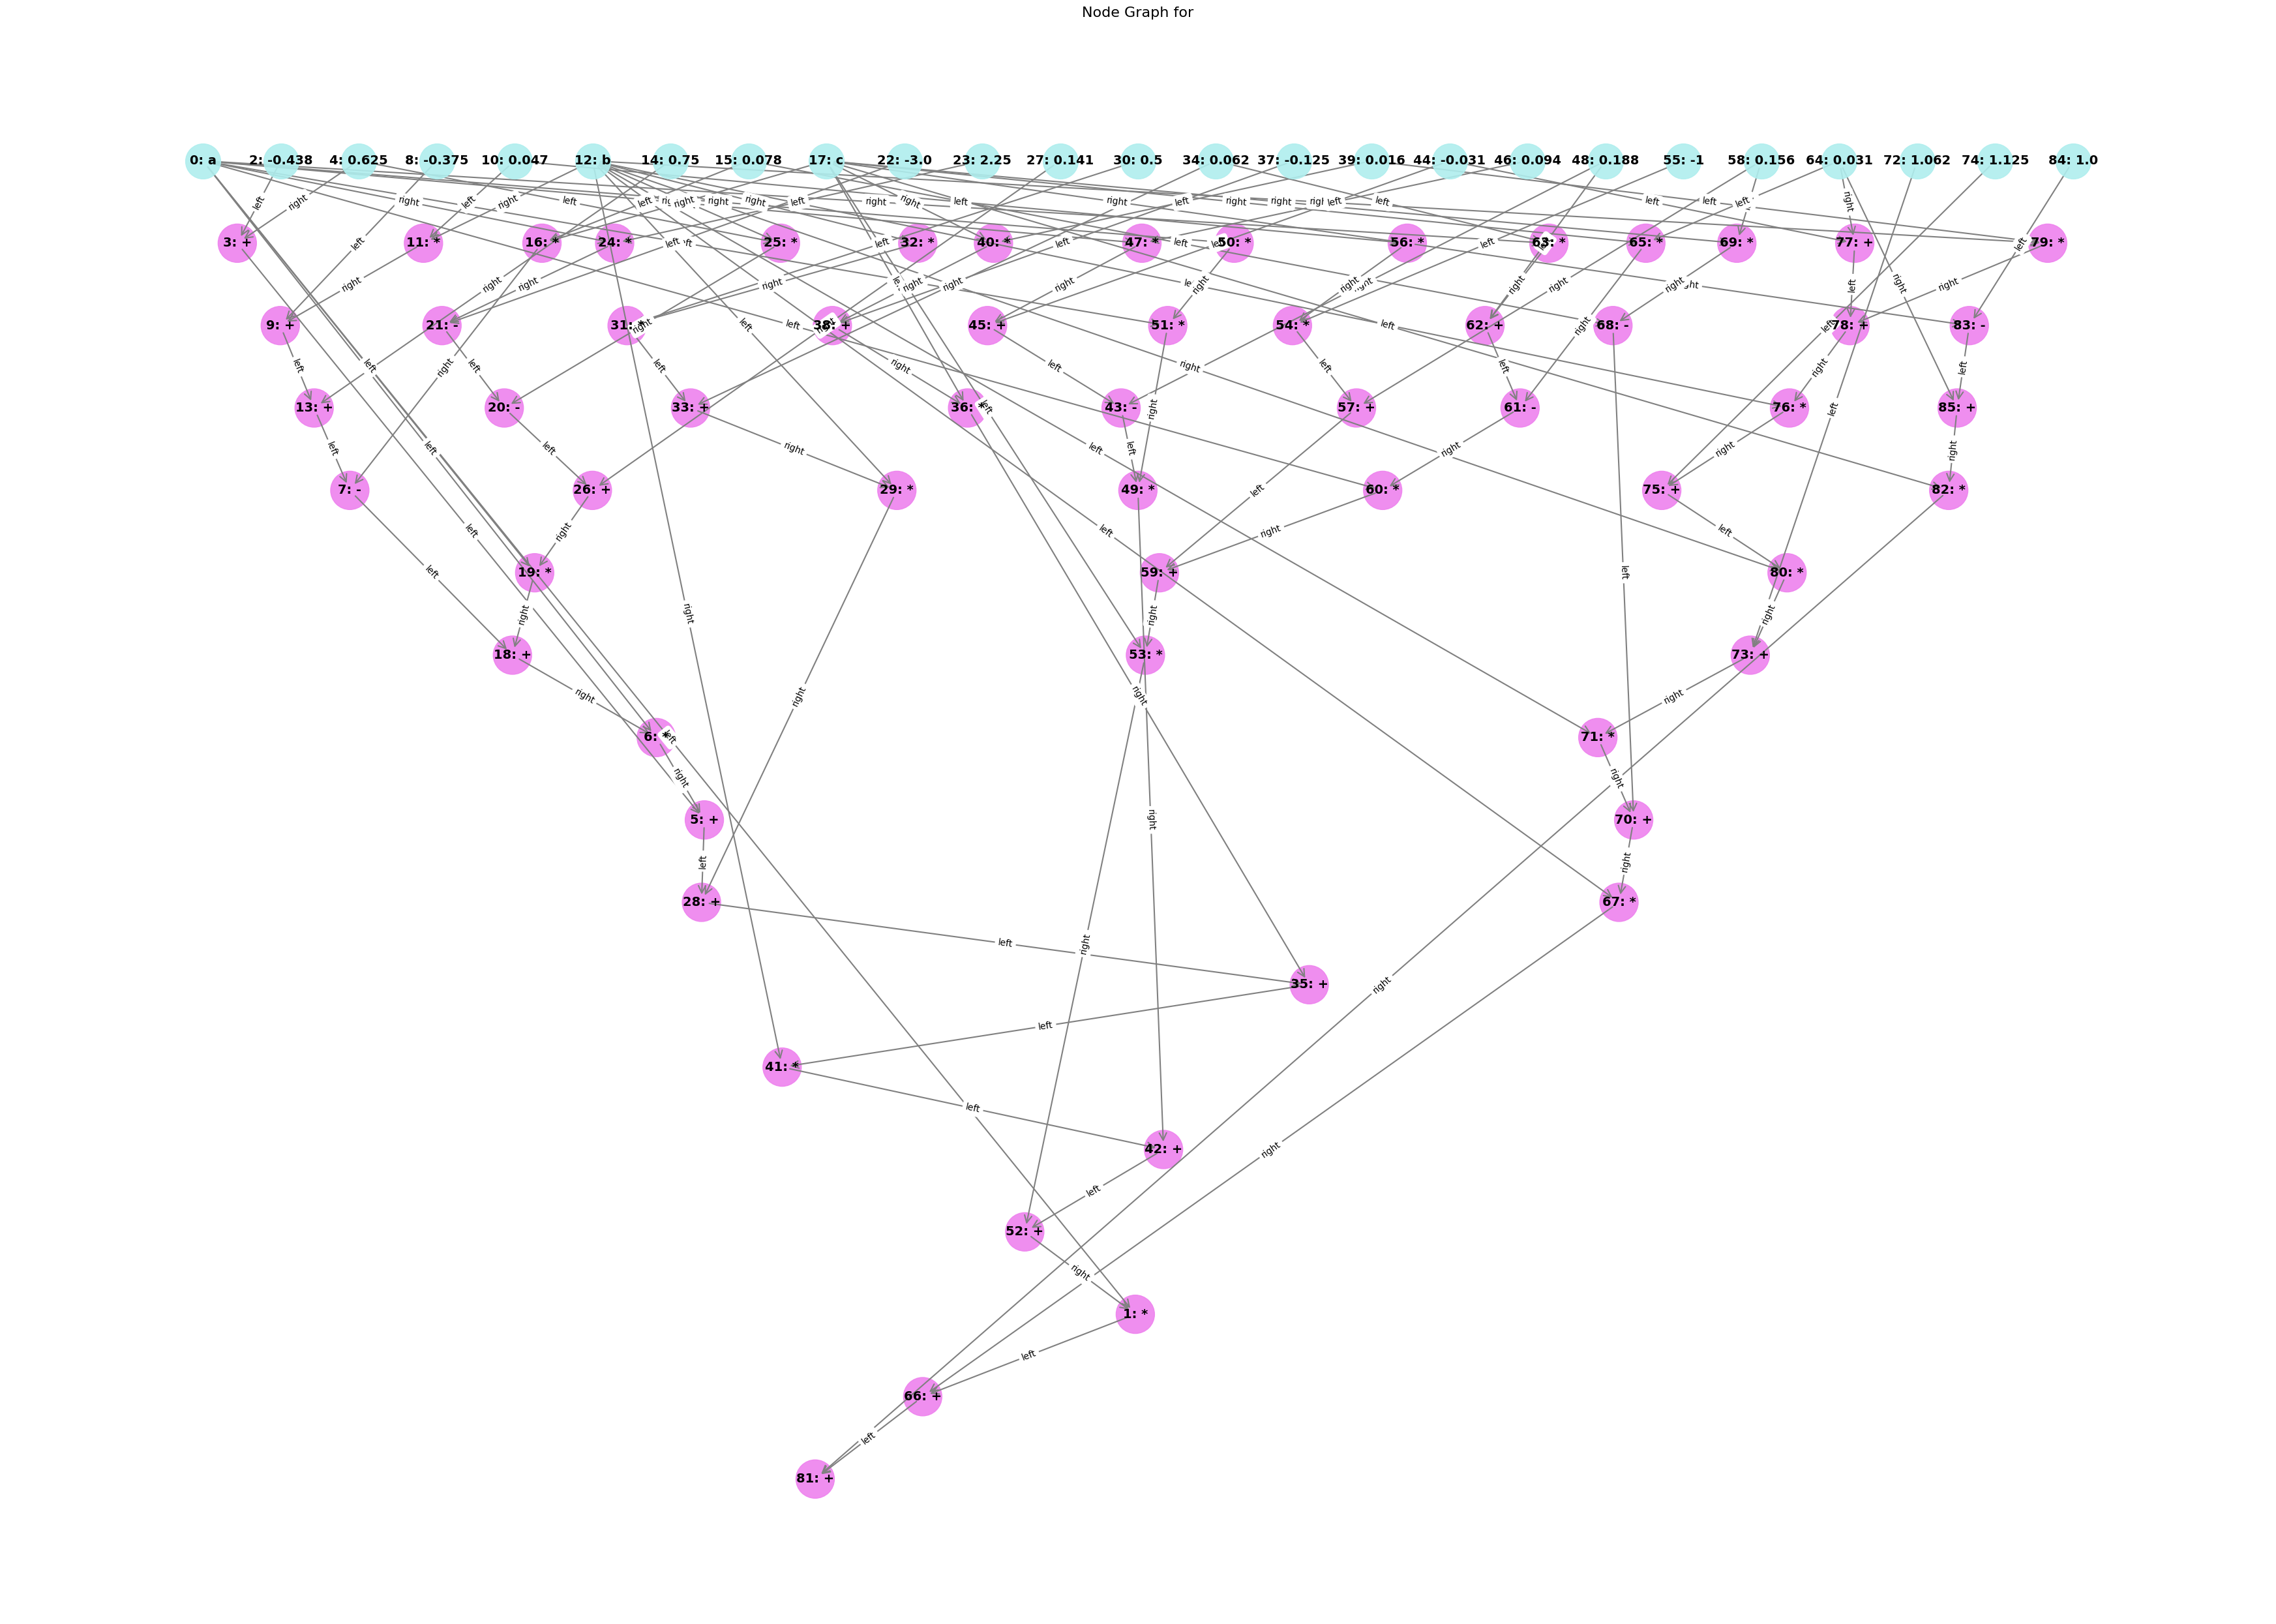

No timing violations found


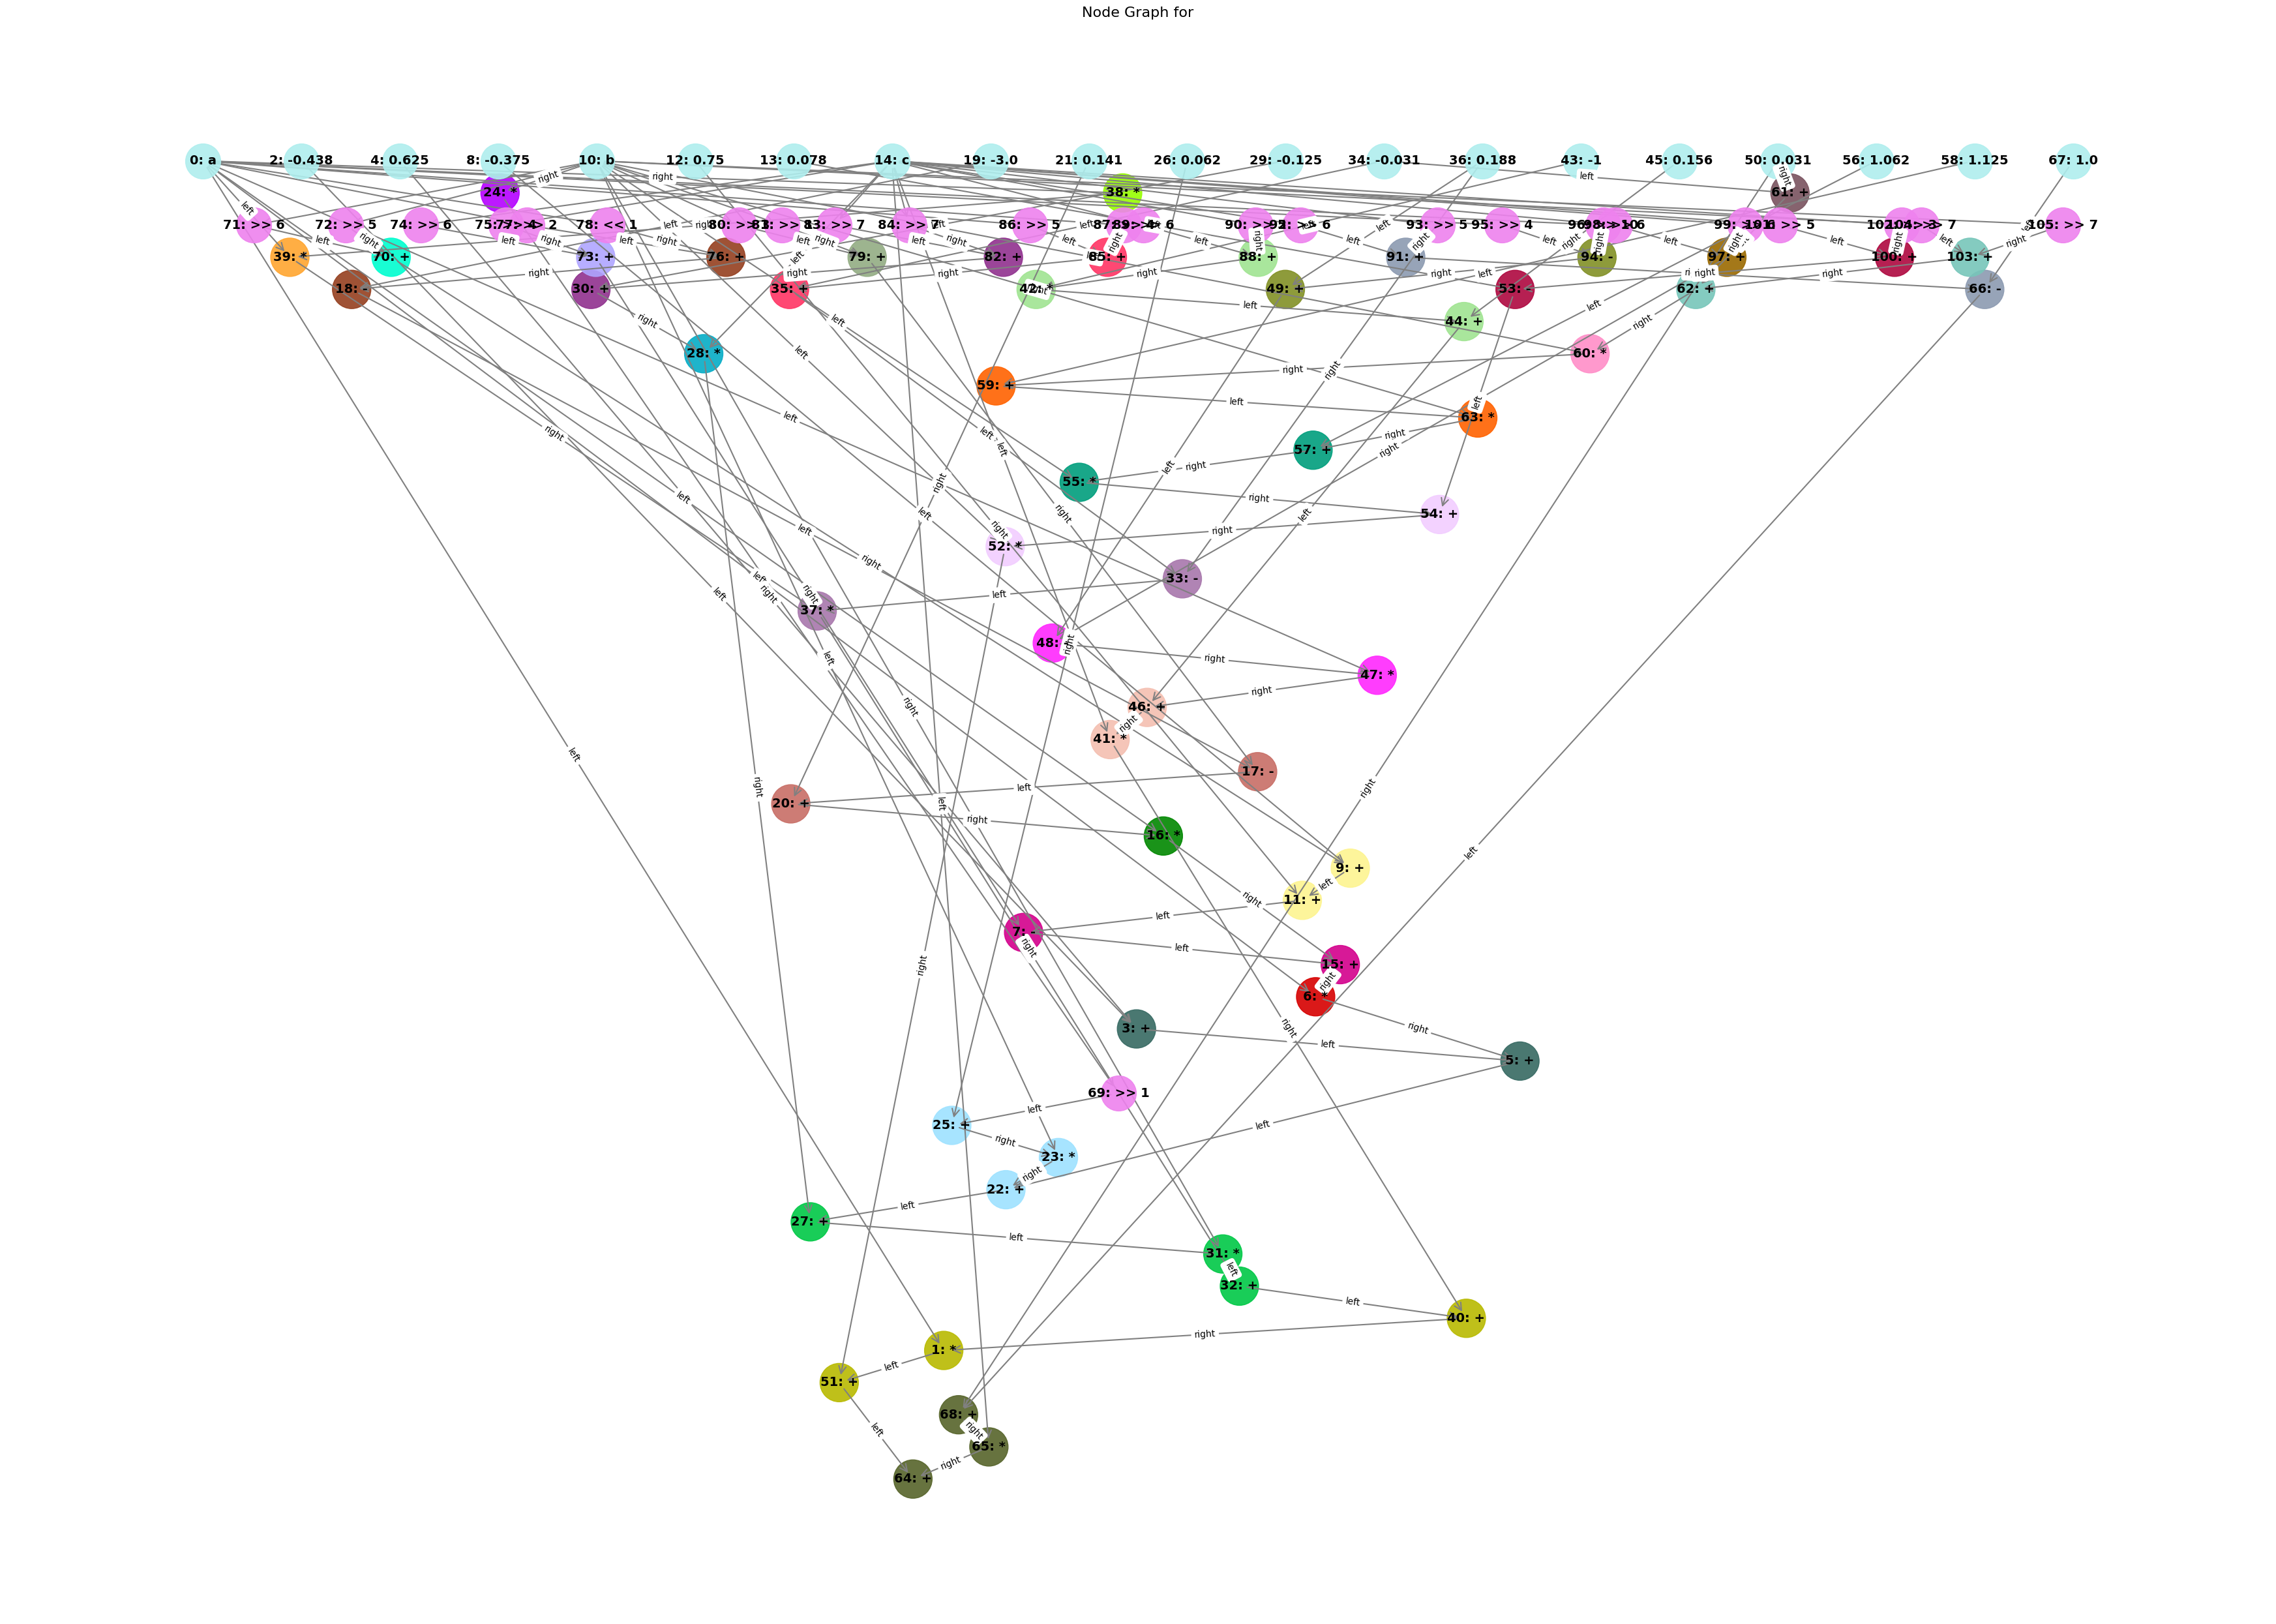

IT is quantised


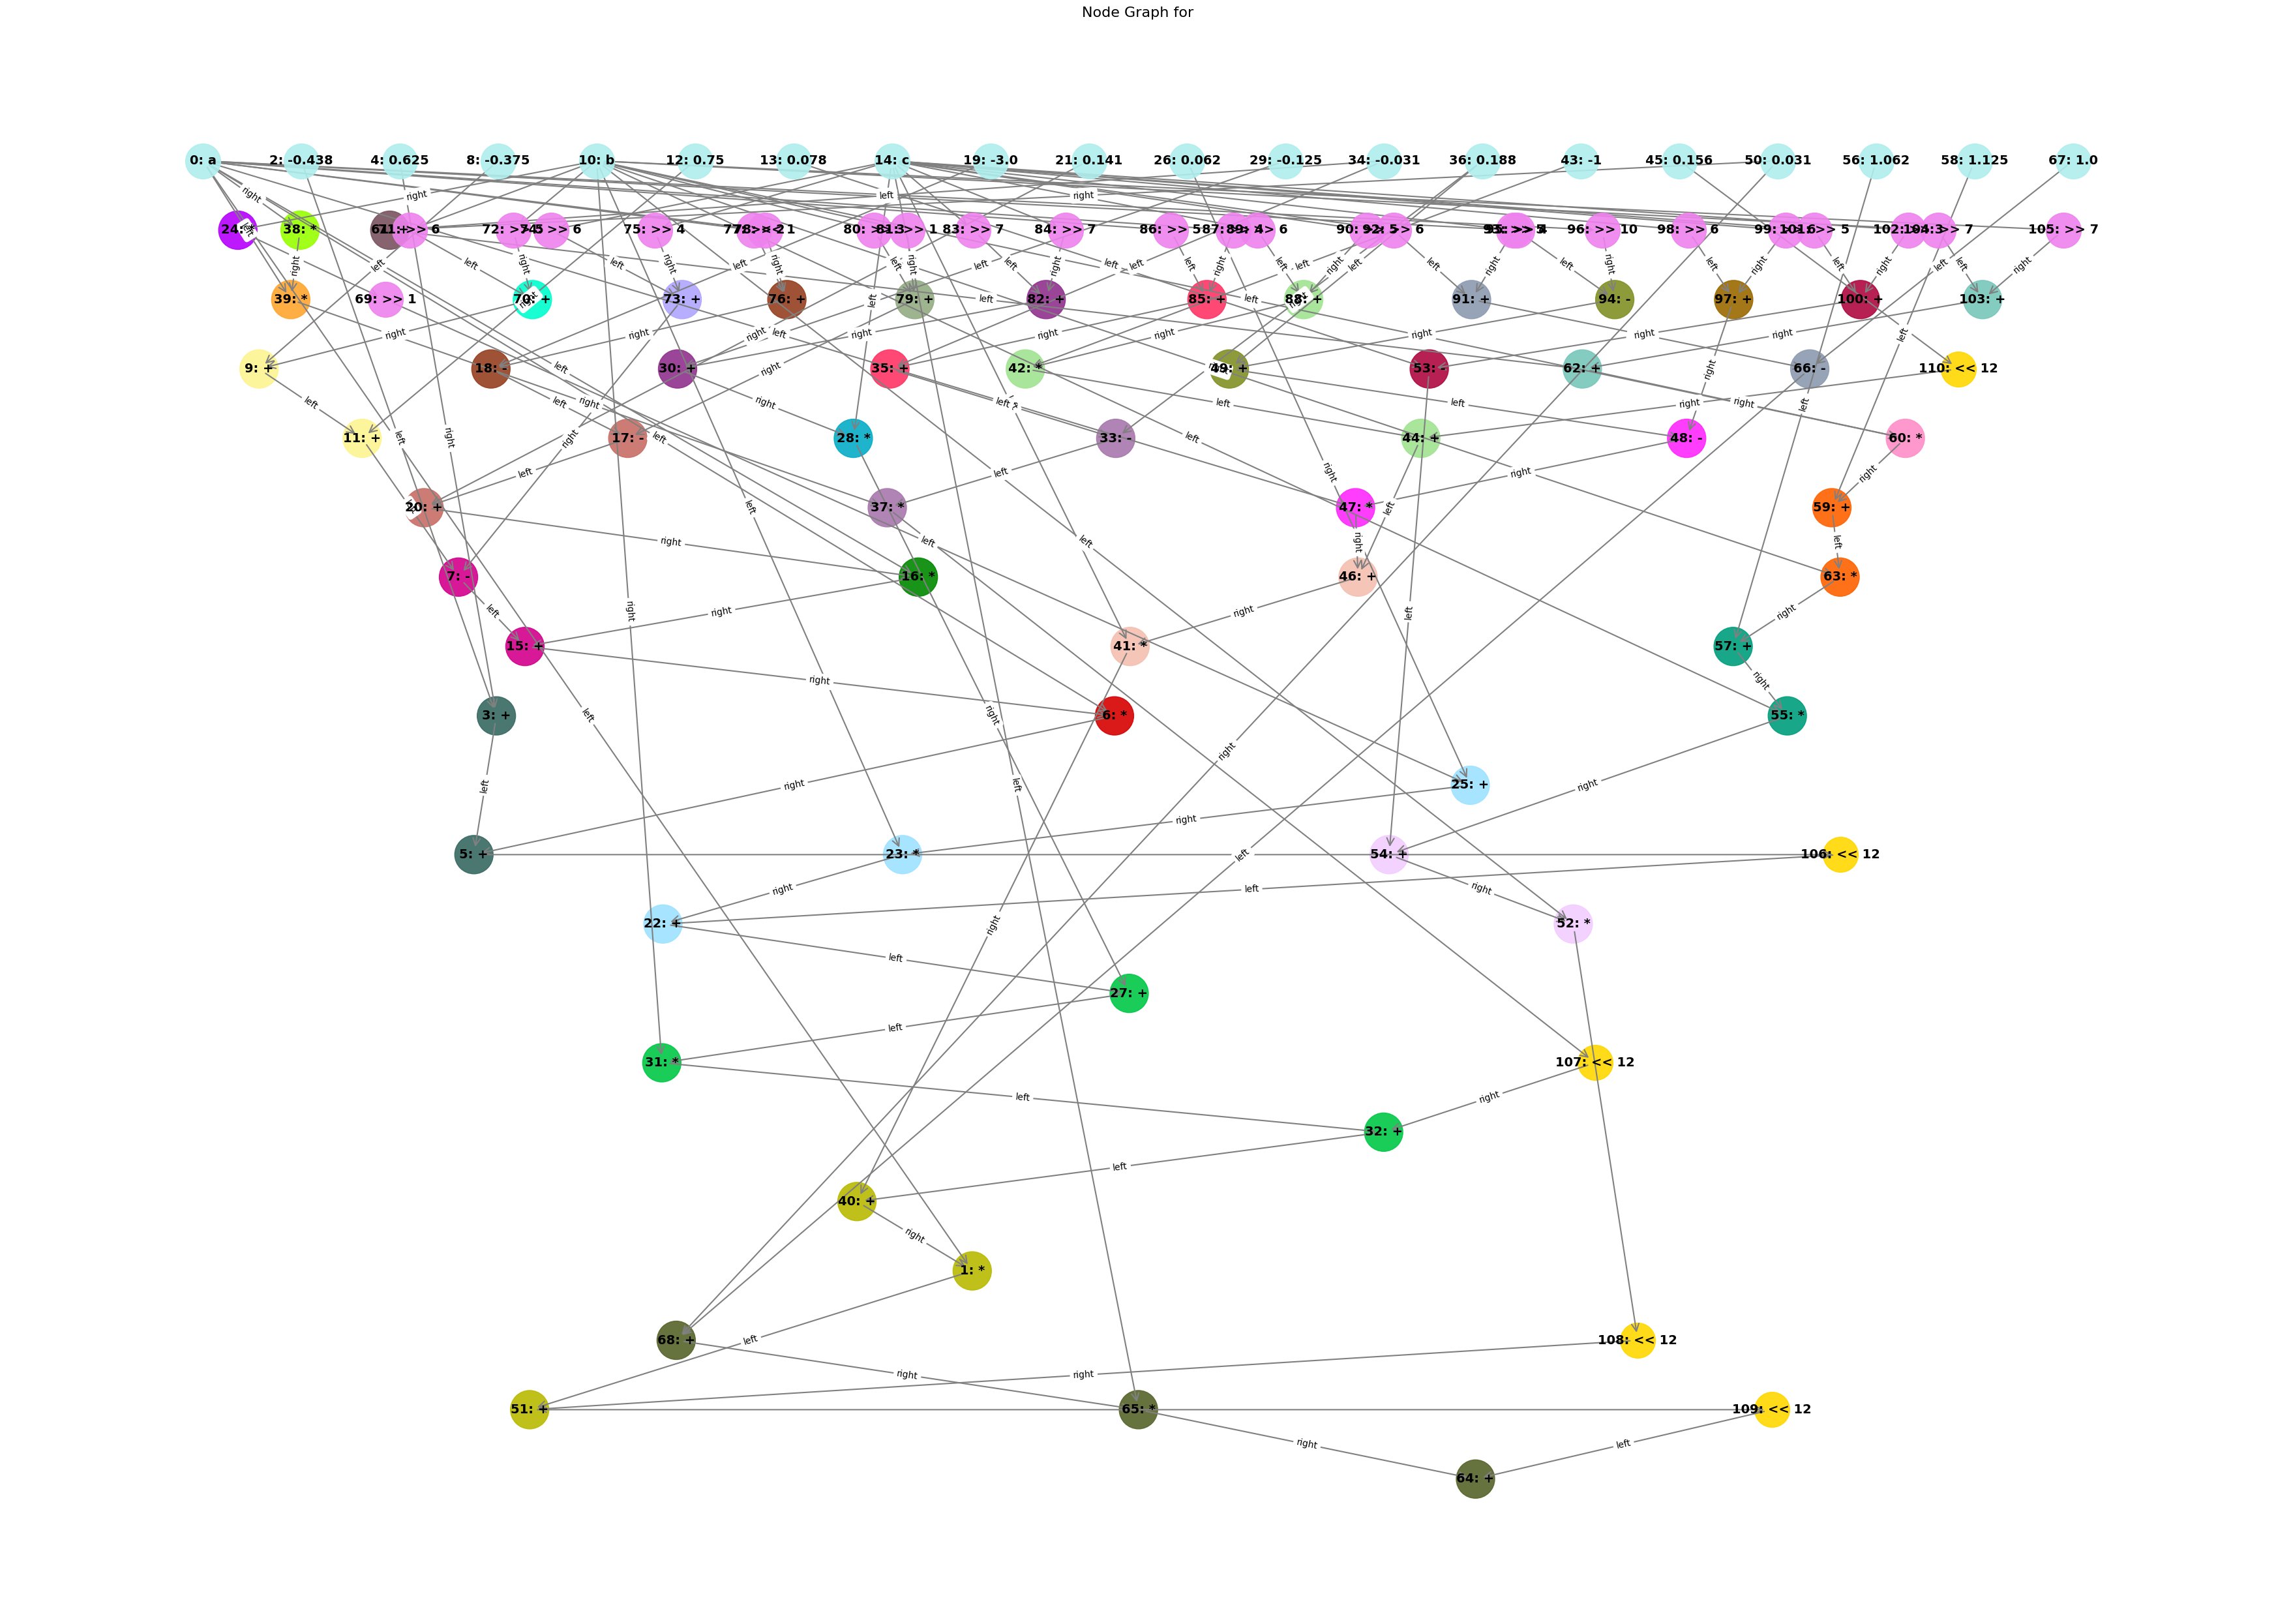

{'a': '0000000100000000000', 'b': '0000001001100110011', 'c': '0000000110011001100'}
-0.438
1111111100011111110
0.625
0000000101000000000
-0.375
1111111101000000000
0.75
0000000110000000000
0.078
0000000000100111111
-3.0
1111101000000000000
0.141
0000000001001000001
0.062
0000000000011111101
-0.125
1111111111000000000
-0.031
1111111111110000010
0.188
0000000001100000010
-1
1111111000000000000
0.156
0000000001001111110
0.031
0000000000001111110
1.062
0000001000011111101
1.125
0000001001000000000
1.0
0000001000000000000
[(0, 'a'), (2, '-0.438'), (4, '0.625'), (8, '-0.375'), (10, 'b'), (12, '0.75'), (13, '0.078'), (14, 'c'), (19, '-3.0'), (21, '0.141'), (26, '0.062'), (29, '-0.125'), (34, '-0.031'), (36, '0.188'), (43, '-1'), (45, '0.156'), (50, '0.031'), (56, '1.062'), (58, '1.125'), (67, '1.0')]
0 0.5
10 1.2
14 0.8
{2: '1111111100011111110', 4: '0000000101000000000', 8: '1111111101000000000', 12: '0000000110000000000', 13: '0000000000100111111', 19: '1111101000000000000', 21: '000000000

In [1]:
import numpy as np
from DataFlowModel import GenerateGraph, CreateTree, GeneratePrecisionGraph
import numpy as np
from fxpmath import Fxp
import matplotlib.pyplot as plt
import operator
import re


# =============================================================================
# DSP Block Analysis Functions
# =============================================================================

def end_dsp_block(node, dsp_combos):

    for combo in dsp_combos:
        last_node = combo[-1]
        if node == last_node:
            return True
    return False


def last_node_in_dsp_with_mult(G, node, dsp_combos):

    for combo in dsp_combos:
        operations = [G.nodes[s]['label'] for s in combo]
        if '*' in operations:
            if node == combo[-1]:
                return True
    return False


def mult_postadder_use(G, node, dsp_combos):

    print(dsp_combos)
    for combo in dsp_combos:
        if len(combo) > 1:
            if last_node_in_dsp_with_mult(G, node, dsp_combos) and G.nodes[combo[-2]]['label'] == '*':
                print('End of DSP Block with multiplier and postadder')
                return True
    return False


# =============================================================================
# Binary Arithmetic Utility Functions
# =============================================================================

def twos_complement_to_int(val_str):

    val = int(val_str, 2)
    bits = len(val_str)
    # Check if the sign bit is set (negative number)
    if (val & (1 << (bits - 1))) != 0: 
        val = val - (1 << bits)        
    return val                        


def int_to_twos_complement(num, bits):

    if num >= 0:
        return format(num, f'0{bits}b')
    else:
        return format((1 << bits) + num, f'0{bits}b')




def resize_to_n_bits(bit_string, n):
    
    if len(bit_string) >= n:
        # Truncate: keep the right-most n bits
        return bit_string[-n:]
    else:
        print(bit_string)
        # Sign extend: pad with the sign bit
        sign_bit = bit_string[0]
        pad_len = n - len(bit_string)
        return (sign_bit * pad_len) + bit_string


# =============================================================================
# DSP Arithmetic Operations
# =============================================================================

def dsp_mult(a, b):

    a_int = twos_complement_to_int(a)
    b_int = twos_complement_to_int(b)

    product = a_int * b_int
    product_bits = len(a) + len(b)
    product_bin = int_to_twos_complement(product, product_bits)
    
    # print(f"Product bits before truncation: {len(product_bin)}")

    # Always resize to 48 bits (DSP block standard width)
    if len(product_bin) < 48:
        sign_bit = product_bin[0]
        pad_len = 48 - len(product_bin)
        product_bin = (sign_bit * pad_len) + product_bin
    
    if len(product_bin) > 48:
        product_bin = product_bin[-48:]  # Keep the least significant 48 bits
    
    print(f"Final product bits: {len(product_bin)}")
    return product_bin


def dsp_add(a, b):

    print("Add", len(a), len(b))
    a_int = twos_complement_to_int(a)
    b_int = twos_complement_to_int(b)

    sum_val = a_int + b_int
    result_bits = max(len(a), len(b)) + 1
    sum_bin = int_to_twos_complement(sum_val, result_bits)

    return sum_bin


def dsp_subtract(a, b):

    a_int = twos_complement_to_int(a)
    b_int = twos_complement_to_int(b)

    diff = a_int - b_int
    result_bits = max(len(a), len(b)) + 1
    diff_bin = int_to_twos_complement(diff, result_bits)

    return diff_bin


# def arithmetic_shift(val_str, shifts, target_bits=None):

#     val = twos_complement_to_int(val_str)

#     if shifts > 0:
#         shifted = val << shifts
#     elif shifts < 0:
#         shifted = val >> -shifts
#     else:
#         shifted = val

#     bits_to_use = target_bits if target_bits else len(val_str)
#     shifted_bin = int_to_twos_complement(shifted, bits_to_use)

#     # Remove any 'b' prefix that might be present
#     if shifted_bin.startswith('b'):
#         shifted_bin = shifted_bin[1:]
    
#     return shifted_bin


def arithmetic_shift(val_str, shifts, target_bits=None):
    val = twos_complement_to_int(val_str)

    if shifts > 0:
        shifted = val << shifts
    elif shifts < 0:
        shifted = val >> -shifts
    else:
        shifted = val

    # Calculate required bits, important for left shifts
    if target_bits is None:
        if shifts > 0:
            bits_to_use = len(val_str) + shifts  
        else:
            bits_to_use = len(val_str)
    else:
        bits_to_use = target_bits
    
    shifted_bin = int_to_twos_complement(shifted, bits_to_use)

    # Remove any 'b' prefix that might be present
    if shifted_bin.startswith('b'):
        shifted_bin = shifted_bin[1:]
    
    return shifted_bin
# =============================================================================
# Expression Evaluation Engine
# =============================================================================

def calculate_expression(G, new_levels, initial_values, quant_initial_values, dsp_combos, b_port_shifts, word_length, n, quantised=False):

    converted_node_results = {}
    print("Initial values", initial_values)

    # Define arithmetic operations
    ops = {
        '+': operator.add,
        '-': operator.sub,
        '*': operator.mul
    }
    
    # Initialize result dictionaries based on computation mode
    if quantised:
        node_results = quant_initial_values  # Binary string results
        number_node_results = initial_values  # Parallel floating-point tracking
    else:
        node_results = initial_values
        number_node_results = {}

    print(number_node_results)

    # Process nodes level by level (topological order)
    for th in range(1, max(new_levels.values()) + 1):
        th_level = [node for node, level in new_levels.items() if level == th]

        for current_node in th_level:
            print("Node: ", current_node)
            
            preds = list(G.predecessors(current_node))
            operation = G.nodes[current_node]['label']
            print("operation: ", operation)

            # Identify current DSP block context
            current_dsp = [combo for combo in dsp_combos if current_node in combo]
            if current_dsp:
                current_dsp = current_dsp[0]
            else:
                current_dsp = None

            print(current_dsp)

            # Process arithmetic operations
            if operation in ('+', '-', '*'):
                # Extract operands based on edge labels
                right = [u for u, v, attr in G.in_edges(current_node, data=True) if attr['label'] == 'right']
                left = [u for u, v, attr in G.in_edges(current_node, data=True) if attr['label'] == 'left']
            
                # Handle squaring operation (single operand multiplication)
                if operation == '*' and len(preds) == 1:
                    if quantised:
                        print("WE ARE SQUARING", preds[0])

                        # Resize to 18 bits for DSP port B compatibility
                        if preds[0] not in current_dsp:
                            port_B = arithmetic_shift(node_results[preds[0]], -b_port_shifts)
                            port_B = resize_to_n_bits(port_B, 18)
                            port_D = resize_to_n_bits(node_results[preds[0]], 25)

                        calculation = dsp_mult(port_B, port_D)

                       
                        number_calculation = number_node_results[preds[0]]**2
                    else:
                        calculation = node_results[preds[0]]**2

                    print("Calculation power: ", calculation)

                else:
                    # Handle binary operations
                    left_value = node_results[left[0]]
                    right_value = node_results[right[0]]

                    print("VALUES are: ", left_value, right_value)

                    if quantised:
                        print("VALUES lengths: ", len(left_value), len(right_value))

                        if operation == '*':

                            # Handle DSP multiplier input sizing
                            if left[0] in current_dsp:
                                # Pre-adder output: resize to 25 bits
                                left_value = resize_to_n_bits(left_value, 25)
                                right_value = arithmetic_shift(right_value, -b_port_shifts)
                                right_value = resize_to_n_bits(right_value, 18)

                            elif right[0] in current_dsp:
                                # Pre-adder output: resize to 25 bits
                                right_value = resize_to_n_bits(right_value, 25)
                                left_value = arithmetic_shift(left_value, -b_port_shifts)
                                left_value = resize_to_n_bits(left_value, 18)

                            else:
                                # First multiplication in DSP: standard port sizes
                                print("Multiplication is first node in DSP")
                                right_value = arithmetic_shift(right_value, -b_port_shifts)
                                right_value = resize_to_n_bits(right_value, 18)

                                left_value = resize_to_n_bits(left_value, 25)

                            calculation = dsp_mult(left_value, right_value)
                            print("After multiplication", calculation, len(calculation))


                        elif operation == '+':

                            if len(current_dsp) == 1:
                                print("This is a postadder on its own")
                                left_value = resize_to_n_bits(left_value, 48)
                                right_value = resize_to_n_bits(right_value, 30)
                                calculation = dsp_add(left_value, right_value)
                                calculation = resize_to_n_bits(calculation, 48)


                            # Operation is the pre-adder
                            elif left[0] not in current_dsp and right[0] not in current_dsp:
                                print("This is a preadder")
                                left_value = resize_to_n_bits(left_value, 25)
                                right_value = resize_to_n_bits(right_value, 30)
                                calculation = dsp_add(left_value, right_value)
                                calculation = resize_to_n_bits(calculation, 25)

                            # Must be the postadder
                            else:
                                print("This is the postadder")
                                left_value = resize_to_n_bits(left_value, 48)
                                right_value = resize_to_n_bits(right_value, 48)
                                calculation = dsp_add(left_value, right_value)
                                calculation = resize_to_n_bits(calculation, 48)



                            print("Calculation addition", left_value, right_value, calculation)

                        elif operation == '-':

                            if len(current_dsp) == 1:
                                print("This is a postadder on its own")
                                left_value = resize_to_n_bits(left_value, 48)
                                right_value = resize_to_n_bits(right_value, 30)

                                calculation = dsp_subtract(left_value, right_value)
                                calculation = resize_to_n_bits(calculation, 48)

                            elif left[0] not in current_dsp and right[0] not in current_dsp:
                                print("This is a preadder")
                                left_value = resize_to_n_bits(left_value, 25)
                                right_value = resize_to_n_bits(right_value, 30)

                                calculation = dsp_subtract(left_value, right_value)
                                calculation = resize_to_n_bits(calculation, 25)


                            # Handle post-subtractor configuration
                            else:
                                print("This is a postadder")
                                left_value = resize_to_n_bits(left_value, 48)
                                right_value = resize_to_n_bits(right_value, 48)


                                calculation = dsp_subtract(left_value, right_value)
                                calculation = resize_to_n_bits(calculation, 48)

                        # Maintain parallel floating-point calculation
                        left_value = number_node_results[left[0]]
                        right_value = number_node_results[right[0]]
                        number_calculation = ops[operation](left_value, right_value)

                    else:
                        # Floating-point calculation
                        calculation = ops[operation](left_value, right_value)

                    print(calculation)

            # Process shift operations
            elif '<<' in operation or '>>' in operation:
                match = re.search(r'(<<|>>)\s*(\d+)', operation)
                direction, exponent = match.groups()

                # Convert right shift to negative left shift
                if direction == '>>':
                    exponent = -int(exponent)
                else:
                    exponent = int(exponent)
                
                if quantised:
                    print("To shift: ", node_results[preds[0]])
                    calculation = arithmetic_shift(node_results[preds[0]], exponent)
                    number_calculation = number_node_results[preds[0]] * (2 ** exponent)
                else:
                    calculation = node_results[preds[0]] * (2 ** exponent)

                print(calculation)

            # Store results with proper formatting
            if quantised:
                if last_node_in_dsp_with_mult(G, current_node, dsp_combos):
                    # Handle DSP output: reduce fractional bits from 2n to n
                    print("DSP output is 48 bits")
                    calculation = resize_to_n_bits(calculation, 48)
                    print("After setting it to 48 bits: ", calculation, len(calculation))
                    
                    # Shift to remove excess fractional bits
                    if n > 0 and b_port_shifts == 0:
                        val = twos_complement_to_int(calculation)
                        val = val >> n 
                        calculation_shifted = int_to_twos_complement(val, 50)
                        calculation_shifted = resize_to_n_bits(calculation_shifted, word_length)
                    elif n > 0 and b_port_shifts > 0:
                        print("BPORT SHIFT: ", n - b_port_shifts)
                        compensation_shift = n - b_port_shifts
                        calculation_shifted = arithmetic_shift(calculation, -compensation_shift)
                        
                        # calculation_shifted = int_to_twos_complement(val, 50)
                        calculation_shifted = resize_to_n_bits(calculation_shifted, word_length)
                    else:
                        calculation_shifted = resize_to_n_bits(calculation, word_length)
                    
                    # calculation_shifted = resize_to_n_bits(calculation_shifted, word_length)
                    print("Truncated before adding: ", calculation_shifted, len(calculation_shifted))
                    
                    node_results[current_node] = str(calculation_shifted)
                else:

                    # Adds node with the specific word length set
                    node_results[current_node] = str(calculation)
                    print("Added node with length", len(calculation))

                # Store parallel results
                number_node_results[current_node] = float(number_calculation)

                # Convert binary result to floating-point for verification
                v = node_results[current_node]
                converted_node_results[current_node] = float(Fxp("0b" + str(v), signed=True, n_word=len(v), n_frac=n))
            else:
                print(float(calculation))
                node_results[current_node] = float(calculation)

            print(node_results)
            print(converted_node_results)
            print(number_node_results)

    # Display final results
    print("Node result: ", node_results)

    if quantised:
        # Show result from the deepest (final) node
        deepest_node = max(new_levels, key=new_levels.get)
        v = node_results[deepest_node]
        float_v = float(Fxp("0b" + str(v), signed=True, n_word=len(v), n_frac=n))
        print(float_v)

        return float_v
    else:
        deepest_node = max(new_levels, key=new_levels.get)
        v = node_results[deepest_node]
        print(v)

        return v


# =============================================================================
# Input Processing and Initialization
# =============================================================================

def is_numeric_string(s):

    try:
        float(s)
        return True
    except ValueError:
        return False


def initial_values(G, new_levels, value_mapping, quant_value_mapping, word_length, n):

    starting_nodes = []
    quant_vars = {}
    vars = {}

    # Identify all starting nodes (level 0)
    for node, level in new_levels.items():
        if level == 0:
            starting_nodes.append((node, G.nodes[node]['label']))

    # Process numeric constants
    for node, node_name in starting_nodes:
        if is_numeric_string(node_name):
            print(node_name)
            # Convert constant to fixed-point representation
            fxp_val = Fxp(float(node_name), signed=True, n_word= 48, n_frac=n)
            fxp_val = fxp_val.bin()
            fxp_val = resize_to_n_bits(fxp_val, word_length)
            print(fxp_val)
            quant_vars[node] = fxp_val
            vars[node] = float(node_name)

    # Process variable mappings
    print(starting_nodes)
    for node_num, var_name in starting_nodes:
        if var_name in value_mapping:
            print(node_num, value_mapping[var_name])
            vars[node_num] = value_mapping[var_name]
            quant_vars[node_num] = quant_value_mapping[var_name]

    print(quant_vars)           
    return vars, quant_vars


def quantise_dict(value_dict, word_length, n):

    quantised_values = {}
    for key, value in value_dict.items():
        fxp_val = Fxp(value, signed=True, n_word=word_length, n_frac=n)
        quantised_values[key] = fxp_val.bin()

    return quantised_values


# =============================================================================
# Main Execution
# =============================================================================


# Configuration parameters
# user_input = "a^2 + 8*c^2 - 3*a*b + 5*c*a - 4*(a+b)"
# Alternative test expressions:
user_input = "0.094 * a^4.0 + (- 0.438 + 0.625 + 0.016 * c^2.0) * b + (c) * (0.156 + (a) * (0.188 + 0.062 * a))"
# user_input = "4*x + 2*y + z^2"

user_input = "a * ((-0.438 + 0.625 + a * (-0.375 + 0.047 * b + 0.75 - 0.078 * c + a * (-3.0 - 2.25 * a - 0.625 * b + 0.141)) + b * (0.5 * b^2.0 + 0.062) + c * (-0.125 + 0.016 * c)) * b + (-0.031 + 0.094 * a - 0.188) * a^3.0 + c * (-(0.047 * c) + 0.156 + a * (0.188 + 0.062 * a - 0.031 * c))) + b * (0.078 - 0.156 * c + b * (1.062 + (1.125 + b * (-0.031 + 0.031 + 0.016 * b)) * b)) + c * (1.0 - 0.047 * c + 0.031)"
# user_input = "a * ((-0.438 + 0.625 + a * (-0.375 + 0.047 * b + 0.75 - 0.078 * c + a * (-3.0 - 2.25 * a - 0.625 * b + 0.141)) + b * (0.5 * b^2.0 + 0.062) + c * (-0.125 + 0.016 * c)) * b + (-0.031 + 0.094 * a - 0.188) * a^3.0 + c * (-(0.047 * c) + 0.156 + a * (0.188 + 0.062 * a - 0.031 * c))) + b * (0.078 - 0.156 * c + b * (1.062 + (1.125 + b * (-0.031 + 0.031 + 0.016 * b)) * b))"


quant = True
m = 7
n = 12

word_length = n + m

# B port shifts cannot be larger than n or 7
b_port_shifts = 0

# Generate computation graph with DSP block optimization
G_mod, dsp_combos, split_stage_levels = GeneratePrecisionGraph(
    user_input, 
    frac_bit_num=n, 
    show_graph=True, 
    quantised=quant,
    b_port_shifts = b_port_shifts
)

# Define variable values
value_mapping = {'a': 0.5, 'b': 1.2, 'c': 0.8}

# Create quantized versions of input values
quant_value_mapping = quantise_dict(value_mapping, word_length, n)
print(quant_value_mapping)

# Initialize computation
init_val, quant_init_val = initial_values(
    G_mod, split_stage_levels, value_mapping, quant_value_mapping, word_length, n
)

# Execute computation
calculate_expression(
    G_mod, split_stage_levels, init_val, quant_init_val, dsp_combos, b_port_shifts,
    quantised=quant, word_length=word_length, n=n
)

# Verification: calculate reference result using Python evaluation
a, b, c = value_mapping['a'], value_mapping['b'], value_mapping['c']
result = eval(user_input.replace('^', '**'))  # Convert ^ to ** for Python
print("Calculation result:", result)

In [2]:
dsp_combos

[[6],
 [16],
 [24],
 [28],
 [38],
 [39],
 [60],
 [61],
 [70],
 [73],
 [79],
 [97],
 [3, 5],
 [7, 15],
 [9, 11],
 [17, 20],
 [25, 23, 22],
 [27, 31, 32],
 [33, 37],
 [40, 1, 51],
 [46, 41],
 [48, 47],
 [54, 52],
 [57, 55],
 [59, 63],
 [68, 65, 64],
 [76, 18],
 [82, 30],
 [85, 35],
 [88, 42, 44],
 [91, 66],
 [94, 49],
 [100, 53],
 [103, 62]]